# (11) Gabor: CIFAR

**Motivation**: Fit log-gabor to ```CIFAR10-PATCHES``` data. Device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from analysis.eval import sparse_score
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## Fig save dir

In [2]:
fig_dir = pjoin(fig_base_dir, 'nips_may22')
os.makedirs(fig_dir, exist_ok=True)
print(os.listdir(fig_dir))

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

[]

## Device

In [3]:
device_idx = 0
device = f'cuda:{device_idx}'

model_type = 'poisson'

## Load model

In [4]:
name = '/'.join([
    'poisson_uniform_c(-3)_rmax(0.99)_CIFAR10-PATCHES_z-512_<lin|lin>',
    'mc_b1000-ep3600-lr(0.005)_beta(1:0x0.5)_temp(0.05:exp-1)_gr(500)_(2024_04_27,21:23)'  # (best: 0.97)
])
tr, meta = load_quick(name, device=device, lite=False)
data, loss, etc = tr.validate()

print(meta)

{
    'checkpoint': 3600,
    'global_step': 720000,
    'file': 'PoissonVAE+TrainerVAE-3600_(2024_04_27,23:42).pt',
    'path': 
'/home/hadi/Projects/PoissonVAE/models/poisson_uniform_c(-3)_rmax(0.99)_CIFAR10-PATCHES_z-512_<lin|lin>/mc_b1000-ep
3600-lr(0.005)_beta(1:0x0.5)_temp(0.05:exp-1)_gr(500)_(2024_04_27,21:23)'
}

In [6]:
tr.model.datetime

'2024_04_28,08:43'

### Print loss + identify dead neurons

In [7]:
def _valid(tr):
    data, loss, rates = tr.validate()
    _loss = {k: v.mean() for k, v in loss.items()}
    _loss['tot'] = _loss['mse'] + _loss['kl']
    print(_loss)

    return data, loss, rates

In [12]:
data, loss, rates = _valid(tr)

dead_thres = 0.01
dead = loss['kl_diag'] < dead_thres

dead.sum()

{'mse': 132.68205, 'kl': 34.6277, 'kl_diag': 0.06763223, 'tot': 167.30975}

2

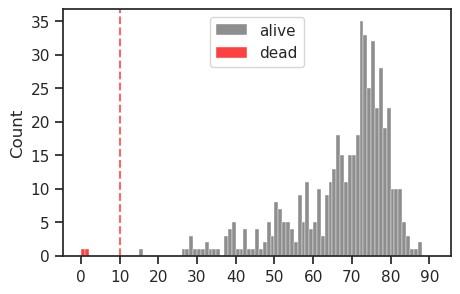

In [13]:
bins = np.linspace(0, 91, 92)
ax = sns.histplot(loss['kl_diag'][~dead] * 1000, bins=bins, color='dimgrey', label='alive')
sns.histplot(loss['kl_diag'][dead] * 1000, bins=bins, color='r', label='dead', ax=ax)
ax.axvline(dead_thres * 1000, color='r', ls='--', alpha=0.6)
ax.locator_params(axis='x', nbins=11)
ax.legend()
plt.show()

## Log-Gabor fit

In [14]:
from analysis.eval import fit_loggabor
from figures.theta import plot_theta

In [15]:
results = fit_loggabor(tr, verbose=True)

 62%|██████▊    | 317/512 [00:08<00:05, 35.13it/s]

100%|███████████| 512/512 [00:12<00:00, 39.63it/s]


In [16]:
results.loc[results['sf_0'] > 10, 'sf_0'] = np.nan
results.iloc[np.logical_or(dead, np.isnan(results['theta']))] = np.nan
results.describe()

,x_pos,y_pos,theta,sf_0,phase,B_sf,B_theta,theta_deg,r_prior
count,510.000000,510.000000,510.000000,509.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,7.648885,7.531957,0.097947,0.267863,0.044522,0.549165,0.301984,90.670799,0.531525
std,4.171349,4.131257,0.886259,0.116375,1.711818,0.141882,0.075320,53.884708,0.189848
min,0.044672,0.651915,-1.557666,0.198465,-3.414377,0.395720,0.112109,0.086142,0.007194
25%,4.204466,4.026962,-0.682875,0.246092,-1.579681,0.472837,0.261240,44.748025,0.429246
50%,7.713802,7.547806,0.026861,0.257382,0.362996,0.515874,0.302323,89.999823,0.589293
75%,11.065269,11.110763,0.840821,0.267689,1.600539,0.592616,0.332758,134.333668,0.665971
max,14.951844,14.417488,1.570796,2.614070,3.773471,2.342987,0.659906,179.969663,1.490698


## Make figs

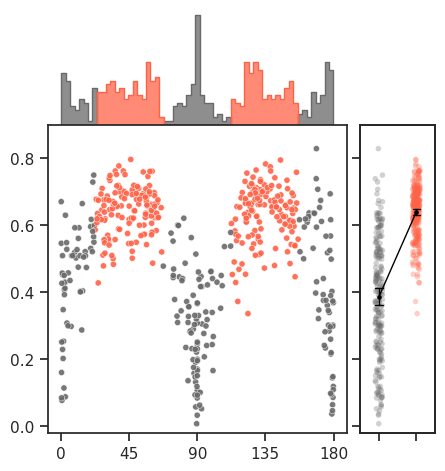

In [29]:
fig, _ = plot_theta(results, ylim=(-0.02, 0.9))

In [30]:
rates_axial = results.loc[(results['label'] == 'axial') & ~dead, 'r_prior'].values
rates_oblique = results.loc[(results['label'] == 'oblique') & ~dead, 'r_prior'].values

In [32]:
print(f"{sp_stats.mannwhitneyu(rates_axial, rates_oblique, method='auto')}")

MannwhitneyuResult(statistic=6174.0, pvalue=9.736248935369782e-55)

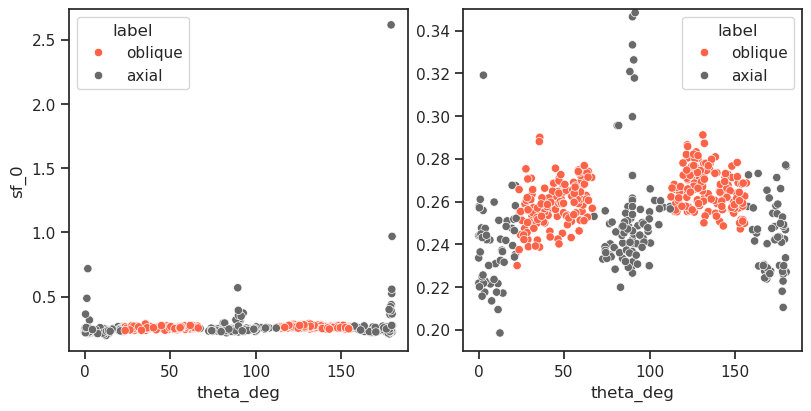

In [46]:
pal = {'axial': 'dimgrey', 'oblique': 'tomato'}

fig, axes = create_figure(1, 2, (8, 4), layout='constrained')
sns.scatterplot(data=results, y='sf_0', x='theta_deg', hue='label', palette=pal, ax=axes[0])
sns.scatterplot(data=results, y='sf_0', x='theta_deg', hue='label', palette=pal, ax=axes[1])
axes[1].set(ylim=(0.19, 0.35), ylabel='')
plt.show()

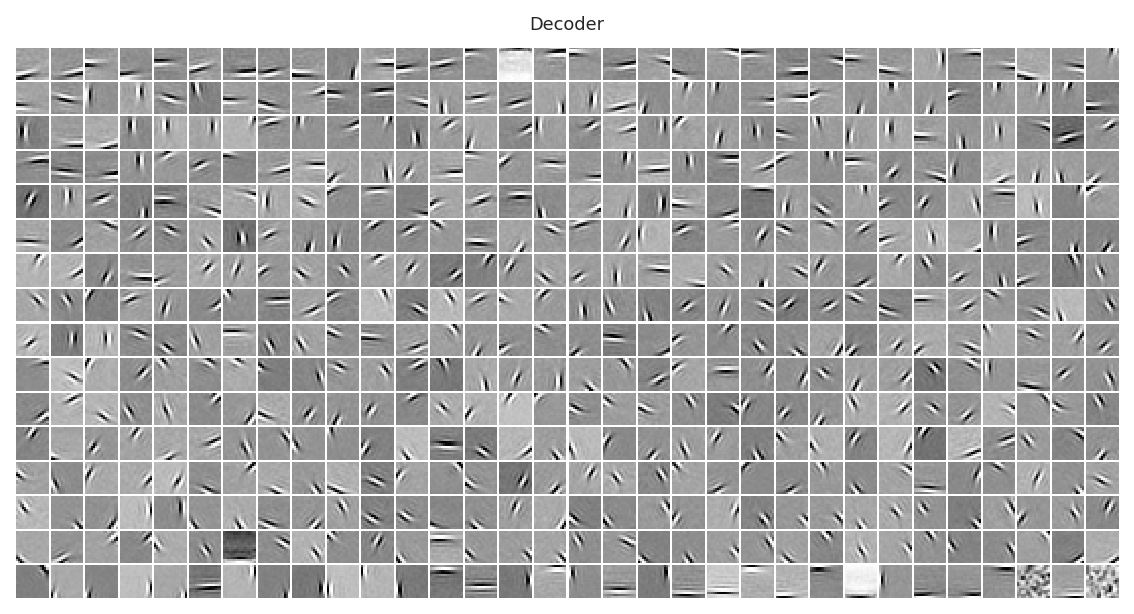

In [48]:
order = np.argsort(results['sf_0'].values)
_ = tr.model.show(order=order)

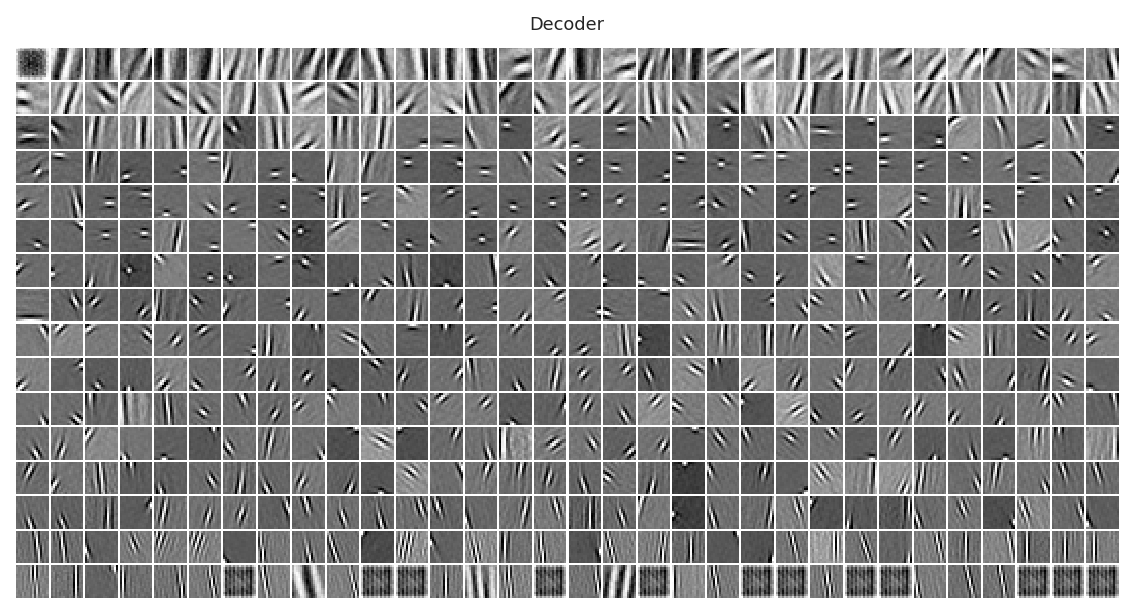

In [32]:
### Was: DOVES

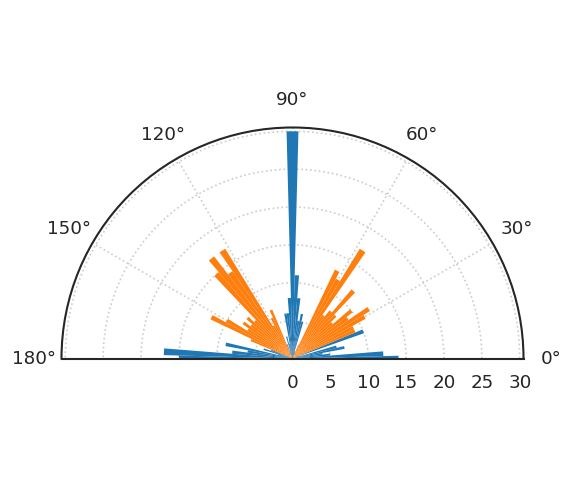

In [56]:
bin_width = 3.0
bins = np.linspace(
    start=0,
    stop=180 + bin_width,
    num=int(np.ceil(180 / bin_width)) + 2,
) - bin_width / 2
bin_mid = np.deg2rad((bins[:-1] + bins[1:]) / 2)

axial_hist, _ = np.histogram(results.loc[results['label'] == 'axial', 'theta_deg'], bins)
oblique_hist, _ = np.histogram(results.loc[results['label'] == 'oblique', 'theta_deg'], bins)

fig, ax = create_figure(1, 1, (8, 5), dpi=120, subplot_kw={'polar': True})
ax.set_thetamin(0)
ax.set_thetamax(180)
ax.set_theta_direction(1)  # Counter-clockwise
ax.set_theta_zero_location('E')  # 0 degrees to the left

ax.bar(bin_mid, axial_hist, width=np.radians(bin_width), color='C0', edgecolor='none', label='Axial')
ax.bar(bin_mid, oblique_hist, width=np.radians(bin_width), color='C1', edgecolor='none', label='Oblique', bottom=axial_hist)
ax.legend(fontsize=9)
move_legend(ax)
ax.set_ylim((0, 30.5))
plt.show()

In [57]:
collections.Counter(results['label'])

Counter({'oblique': 292, 'axial': 218, nan: 2})

In [41]:
### Was: DOVES

Counter({'axial': 297, 'oblique': 209, nan: 6})

### High and low spatial frequencies

In [59]:
from figures.imgs import plot_weights

In [60]:
w_dec = to_np(tr.model.fc_dec.weight.data)
w_dec = w_dec.T.reshape(-1, 16, 16)
ids = np.argsort(results['sf_0'].values)

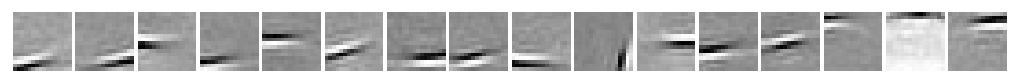

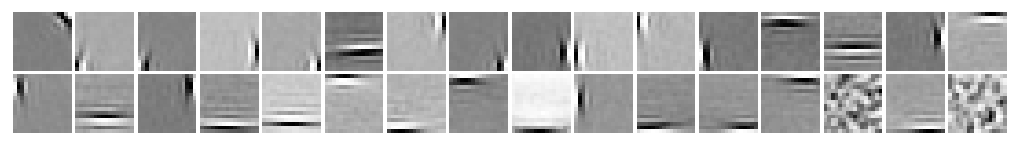

In [64]:
plot_weights(w_dec[ids[:16]], nrows=1, dpi=130)
plt.show()

plot_weights(w_dec[ids[-32:]], nrows=2, dpi=130)
plt.show()

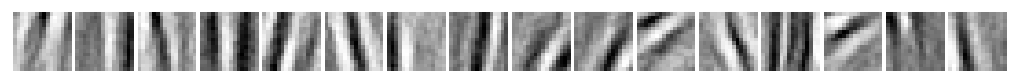

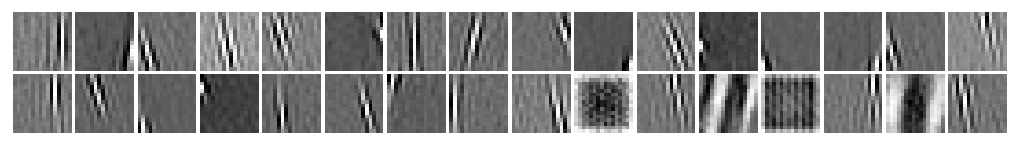

In [66]:
### Was: DOVES

## statistical tests

In [65]:
rates_axial = results.loc[(results['label'] == 'axial') & ~dead, 'r_prior'].values
rates_oblique = results.loc[(results['label'] == 'oblique') & ~dead, 'r_prior'].values

In [66]:
sp_stats.mannwhitneyu(rates_axial, rates_oblique, method='auto')

MannwhitneyuResult(statistic=6174.0, pvalue=9.736248935369782e-55)

In [67]:
sp_stats.mannwhitneyu(rates_axial, rates_oblique, method='exact')

MannwhitneyuResult(statistic=6174.0, pvalue=1.4632844984126762e-66)

In [68]:
sp_stats.ks_2samp(rates_axial, rates_oblique)

KstestResult(statistic=0.6896757571949227, pvalue=2.60964273523401e-57, statistic_location=0.5376478, statistic_sign=1)